# Turing Examples
- categories: [Julia, Turing]

In [8]:
using Turing
using Gadfly
using DataFrames, DataFramesMeta

In [2]:
@model function coinflip(y)
    # prior on p
    p ~ Beta(1, 1)
    
    # updates on p
    for i in 1:length(y)
        y[i] ~ Bernoulli(p)
    end
end

coinflip (generic function with 1 method)

In [3]:
data = [1,1,1,0,0,1,0,0,1,1,1,1,1,0,0,0]

# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 1000
ϵ = 0.05
τ = 10

# Start sampling.
chain = sample(coinflip(data), HMC(ϵ, τ), iterations, progress=false);

In [4]:
chain

Chains MCMC chain (1000×10×1 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = p
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

           p    0.5601    0.1163     0.0037    0.0096   248.9978    0.9992

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.3276    0.4791    0.5643    0.6463    0.7684


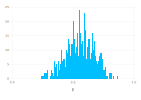

In [9]:
plot(DataFrame(chain), x=:p, Geom.histogram)

In [14]:
function logit(x)
    exp(x) / (1 + exp(x))
end

logit (generic function with 1 method)

In [122]:
data_autocor2 = [1]
p_1 = 0.85
p_2 = 0.15
for i in 2:1000
    if data_autocor2[i-1] == 1
        p = p_1
    else
        p = p_2
    end
    data_autocor2 = cat(data_autocor2, rand(Bernoulli(p)), dims=1)
end

In [123]:
@model function coinflip_autocor(y)
    # prior on p
    p_1 ~ Beta(1, 1)
    p_2 ~ Beta(1, 1)
    
    y[1] ~ Bernoulli(p_1)
    for i in 2:length(y)
        if y[i-1] == 1
            p = p_1
        else
            p = p_2
        end
        y[i] ~ Bernoulli(p)
    end
end

coinflip_autocor (generic function with 1 method)

In [124]:
chain = sample(coinflip_autocor(data_autocor2), HMC(ϵ, τ), iterations, progress=false);

In [125]:
chain

Chains MCMC chain (1000×11×1 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = p_1, p_2
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat 
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64 

         p_1    0.8901    0.0170     0.0005    0.0002    5224.0866    0.9990
         p_2    0.1820    0.0203     0.0006    0.0001   10899.2030    0.9990

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

         p_1    0.8625    0.8817    0.8907    0.8998    0.9145
         p_2    0.1440    0.1681    0.1820    0.1953    0.2214


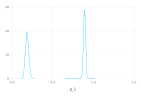

In [126]:
plot(DataFrame(chain), layer(x=:p_1, Geom.density), layer(x=:p_2, Geom.density))

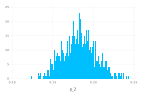

In [127]:
plot(DataFrame(chain), x=:p_2, Geom.histogram)

How to do this with an honest covariance matrix?
What about a "rich get richer" scenario? P(1) ~ b + length of streak of 1s
- would look good but how to diagnose issues?
    - distributions of streaks! a lot of extremely long streaks, a lot of short streaks... 

what about a "machine error" - double readings for both or one of 1s / 0s?

In [128]:
function streaks(arr)
    streaks = []
    val = arr[1]
    current_streak = 1
    for i in 2:length(arr)
        next_val = arr[i]
        if next_val == val
            current_streak = current_streak + 1
        else
            streaks = cat(streaks, current_streak, dims=1)
            val = next_val
            current_streak = 1
        end
    end
    streaks = cat(streaks, current_streak, dims=1)
    return streaks
end

streaks (generic function with 1 method)

In [129]:
streaks([1,1,1,1,2,2,2,2,3,2,1,2,2,2,1])

7-element Array{Any,1}:
 4
 4
 1
 1
 1
 3
 1

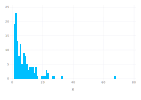

In [130]:
plot(DataFrame(x=streaks(data_autocor2)), x=:x, Geom.histogram)